In [1]:
import sys
sys.path.append("../src/")

In [5]:
import s3fs

fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'})

In [6]:
fs.ls("projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP")

['projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP/ARRONDISSEMENT.cpg',
 'projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP/ARRONDISSEMENT.dbf',
 'projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP/ARRONDISSEMENT.prj',
 'projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP/ARRONDISSEMENT.shp',
 'projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP/ARRONDISSEMENT.shx',
 'projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP/CANTON.cpg',
 'projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP/CANTON.dbf',
 'projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/

In [7]:
import geopandas as gpd

region_border = gpd.read_file("s3://projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP/REGION.shp")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


<Axes: >

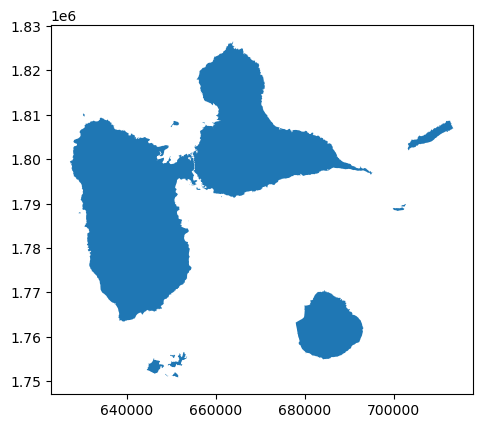

In [8]:
region_border.geometry.plot()

In [9]:
from pathlib import Path
import re

def dep_from_train_path(path: str):
    """
    Get and return dep from train image path.

    Args:
        path (str): Path of train image.
    Return:
        str: Département.
    """
    file_name = Path(path).name
    pattern = r"^(.*?)-"

    # Use re.match to find the match at the beginning of the string
    match = re.match(pattern, file_name)

    if match:
        dep = match.group(1)
        if dep not in [
            "mayotte",
            "guadeloupe",
            "martinique",
            "guyane"
        ]:
            raise ValueError(f"Département {dep} not valid.")
    else:
        raise ValueError("Département not found in path.")
    return dep

In [23]:
# Get a few satellite images
paths = [
    "../../train_data2-segmentation-PLEIADES-BDTOPO-segmentation-dummy-2022/images/mayotte-ORT_2020052526670967_0522_8592_U38S_8Bits_0000.jp2",
    "../../train_data2-segmentation-PLEIADES-BDTOPO-segmentation-dummy-2022/images/mayotte-ORT_2020052526670967_0522_8592_U38S_8Bits_0001.jp2",
    "../../train_data2-segmentation-PLEIADES-BDTOPO-segmentation-dummy-2022/images/mayotte-ORT_2020052526670967_0522_8592_U38S_8Bits_0002.jp2",
    "../../train_data2-segmentation-PLEIADES-BDTOPO-segmentation-dummy-2022/images/mayotte-ORT_2020052526670967_0522_8592_U38S_8Bits_0003.jp2"
]
dep_from_train_path(paths[0])

'mayotte'

In [24]:
from classes.data.satellite_image import SatelliteImage

In [25]:
file_path = paths[0]
dep = dep_from_train_path(paths[0])

img = SatelliteImage.from_raster(file_path=file_path, dep=dep, date=None, n_bands=3)

In [26]:
guadeloupe_border = gpd.read_file("s3://projet-slums-detection/Donnees/ADMINEXPRESS/guadeloupe/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_GLP/REGION.shp")
martinique_border = gpd.read_file("s3://projet-slums-detection/Donnees/ADMINEXPRESS/martinique/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGAF09UTM20_MTQ/REGION.shp")
guyane_border = gpd.read_file("s3://projet-slums-detection/Donnees/ADMINEXPRESS/guyane/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_UTM22RGFG95_GUF/REGION.shp")
mayotte_border = gpd.read_file("s3://projet-slums-detection/Donnees/ADMINEXPRESS/mayotte/1_DONNEES_LIVRAISON_2023-09-21/ADE_3-2_SHP_RGM04UTM38S_MYT/REGION.shp")

region_borders = {
    "guadeloupe": guadeloupe_border,
    "martinique": martinique_border,
    "guyane": guyane_border,
    "mayotte": mayotte_border
}

In [45]:
from shapely.geometry import box

In [58]:
def is_within_borders(satellite_image: SatelliteImage, area_rate: float = 0.2):
    dep = satellite_image.dep
    try:
        border = region_borders[dep]
    except ValueError:
        raise ValueError(f"Département {dep} does not have registered borders.")
    bounds = satellite_image.bounds
    geom = box(*bounds)

    intersection_area = geom.intersection(border.geometry).area[0]
    return intersection_area / geom.area > area_rate

In [59]:
is_within_borders(img)

True

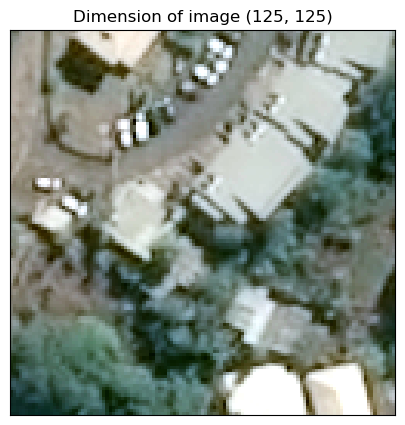

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [54]:
img.plot(bands_indices=[0, 1, 2])

In [68]:
idx = 3

In [69]:
file_path = paths[idx]
dep = dep_from_train_path(paths[idx])

img = SatelliteImage.from_raster(file_path=file_path, dep=dep, date=None, n_bands=3)

In [70]:
is_within_borders(img)

True

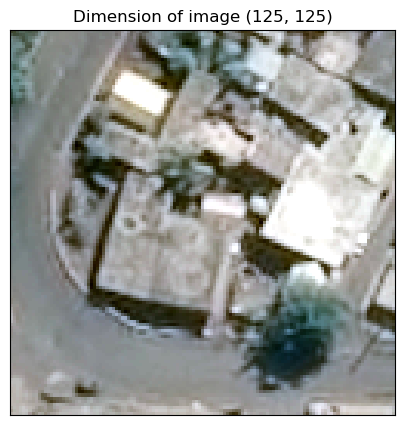

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [71]:
img.plot(bands_indices=[0, 1, 2])

In [75]:
import os

In [ ]:
for idx in range(len(os.listdir(directory))):
    directory = "../../train_data2-segmentation-PLEIADES-BDTOPO-segmentation-dummy-2022/images/"
    file_path = directory + os.listdir(directory)[idx]
    dep = dep_from_train_path(file_path)
    img = SatelliteImage.from_raster(file_path=file_path, dep=dep, date=None, n_bands=3)
    if not is_within_borders(img):
        print(idx)
        break

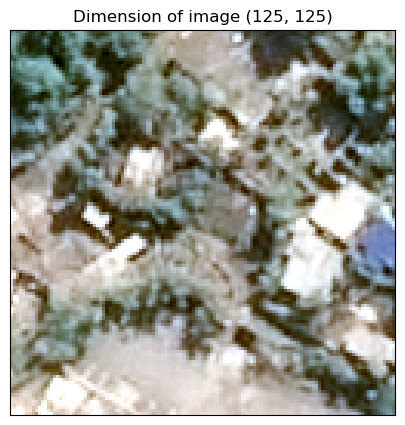

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [104]:
img.plot(bands_indices=[0, 1, 2])